# Observaciones convencionales horarias

Se extraen los datos climáticos horarios de las estaciones automáticas de la AEMET generados en las 24 h últimas. Se pueden descargar todas las estaciones o de las estaciones determinadas.

Si se hiciera recurrentemente se 

In [1]:
import os
base_path = os.getcwd().replace('\\', '/') +'/'

In [150]:
# cargar funciones de la API de la AEMET
%run funciones_opendata_AEMET.ipynb

In [2]:
import requests

from requests.packages.urllib3.exceptions import InsecureRequestWarning
requests.packages.urllib3.disable_warnings(InsecureRequestWarning)

import pandas as pd
import numpy as np
import datetime
import time

from pathlib import Path

In [3]:
# Archivo donde está guardada la API key
API_path = base_path + 'apikey_AEMET.txt'
# Carpeta en la que se guardarán las series
series_path = 'F:/Series/AEMET/Clima/Horario/'
series_path = base_path + 'Horario/'
if os.path.exists(series_path) is False:
    os.makedirs(series_path)
# Estaciones a importar: todas o una lista de las que se quiera
codigos = ['todas']
# Archivo con los datos de las estaciones automáticas de la AEMET
ruta_estaciones = base_path + 'Estaciones_Automaticas.csv'

## 1. Estaciones automáticas

Se importa el listado de las estaciones automáticas de la AEMET en toda España. Estas estaciones son las susceptibles de aportar datos por este medio.

In [111]:
estaciones = pd.read_csv(ruta_estaciones)
estaciones.drop(['FID'], axis=1, inplace=True)
estaciones.columns = ['idema', 'ubi', 'PROVINCIA', 'alt', 'COORD_X', 'COORD_Y', 'VAR_OBSERV', 'DATUM', 'TIPO']
estaciones.sort_values('idema', inplace=True)
estaciones.set_index('idema', drop=False, inplace=True)

# Corregir caracteres conflictivos en el nombre de las estaciones
for i in estaciones.index:
    estaciones.loc[i, 'ubi'] = estaciones.loc[i, 'ubi'].replace('/', '-')
    estaciones.loc[i, 'ubi'] = estaciones.loc[i, 'ubi'].replace('"', '')
    estaciones.loc[i, 'ubi'] = estaciones.loc[i, 'ubi'].replace('Á', 'A')
    estaciones.loc[i, 'ubi'] = estaciones.loc[i, 'ubi'].replace('É', 'E')
    estaciones.loc[i, 'ubi'] = estaciones.loc[i, 'ubi'].replace('Í', 'I')
    estaciones.loc[i, 'ubi'] = estaciones.loc[i, 'ubi'].replace('Ó', 'O')
    estaciones.loc[i, 'ubi'] = estaciones.loc[i, 'ubi'].replace('Ú', 'U')
    estaciones.loc[i, 'ubi'] = estaciones.loc[i, 'ubi'].replace('À', 'A')
    estaciones.loc[i, 'ubi'] = estaciones.loc[i, 'ubi'].replace('È', 'E')
    estaciones.loc[i, 'ubi'] = estaciones.loc[i, 'ubi'].replace('Ç', 'C')
    estaciones.loc[i, 'ubi'] = estaciones.loc[i, 'ubi'].replace('Ñ', 'N')

print('Nº de estaciones automáticas de la AEMET: ', estaciones.shape[0])

Nº de estaciones automáticas de la AEMET:  852


In [114]:
estaciones.head(2)

,idema,ubi,PROVINCIA,alt,COORD_X,COORD_Y,VAR_OBSERV,DATUM,TIPO
idema,,,,,,,,,
0002I,0002I,VANDELLOS,TARRAGONA,32.0,825831.0,4541326.0,hreNvIHBVmtTMpP,ETRS89,AUTOMATICAS
0009X,0009X,ALFORJA,TARRAGONA,406.0,832278.0,4570083.0,hHVmtTMpP,ETRS89,AUTOMATICAS


## 1. Extraer todas las estaciones

Se extraen los datos climáticos horarios disponibles de las últimas 24 h.


### 1.2 Extraer datos

##### extract_hourly_all

In [ ]:
extract_hourly_all(API_path, series_path)

{'descripcion': 'exito', 'estado': 200, 'datos': 'https://opendata.aemet.es/opendata/sh/9c512188', 'metadatos': 'https://opendata.aemet.es/opendata/sh/55c2971b'}


In [108]:
import matplotlib.pyplot as plt
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

In [129]:
serie[['idema', 'lon', 'lat', 'alt']].iloc[0]

idema      4093Y
lon        -2.76
lat      39.6561
alt          763
Name: 2020-10-14 19:00:00, dtype: object

In [134]:
data_stn.hr

fint
2020-10-15 12:00:00    67.0
2020-10-15 13:00:00    43.0
2020-10-15 14:00:00    39.0
2020-10-15 15:00:00    65.0
2020-10-15 16:00:00    57.0
2020-10-15 17:00:00    75.0
2020-10-15 18:00:00    82.0
2020-10-15 19:00:00    84.0
Name: hr, dtype: float64

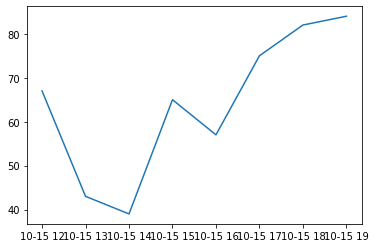

In [136]:
plt.plot(data_stn.hr)

## 2. Extraer una única estación

### 2.1 Funciones

In [ ]:
def extract_data_stn(cod, name, API_path):
    """It extracts hourly climatic data from AEMET's API.
    
    Parameters:
    -----------
    cod:      string. Station code. It must match a index value in the data frame 'stations'.
    stations: data frame. Matrix of available stationes. Its index must be the station's code and it must have a field called
              'ubi' which represents the station's name
    API_path: string. The path where the API key text file is saved, including the name and file extension.
    """
    
    # Extraer de AEMET los datos del último día
    # -----------------------------------------
    # Carga la api key 
    api_key = open(API_path).read().rstrip()
    querystring = {"api_key": api_key}

    raw_data = []
    
    # Mostrar en pantalla la estación de trabajo
    print()
    print('Estación: ', cod, ' - ', name)
    
    # Obtenemos información de todas las estaciones disponibles
    url = ("https://opendata.aemet.es/opendata/api/observacion/convencional/datos/estacion//{station}".format(
            station=cod)
          )
    
    iterate = True
    
    while iterate:
        # Peticion de datos a la url indicada
        r = requests.get(url, params=querystring, verify=False)
        # Si no me deja hacer la conexión, la repito  
        iterate = (r.status_code == requests.codes.too_many_requests)
        print(r.json())
        
        # Chequeo si la petición ha ido bien    
        if r.status_code == requests.codes.ok:
            # Hago la petición para obtener los datos
            data_url = r.json()['datos']
            r_data = requests.get(data_url, params=querystring, verify=False)

            # INCONSISTENCIA DE LA API:
            # Cuando no encuentra datos en el rango seleccionado, la API devuelve
            # que el status code es 200 (todo ok) y devuelve un json con el error
            # cuando encuentra, no hay atributo estado            
            try:
                estado = r_data.json()['estado']
            except:
                estado = 200

            # Si ha ido bien guardo los datos
            if estado == requests.codes.ok:
                #print(r_data.json())
                raw_data.extend(r_data.json())
            else:
                print(r_data.json()['descripcion'])
        else:
            print(r.json()['descripcion'])

        time.sleep(60/45)
    return raw_data

In [ ]:
def generate_serie_stn(cod, name, raw_data, path):
    """It joins the past and present series of hourly climatic data. If there's not previous data, it simply creates a new
    csv file with the hourly data from the last 24 h.
    
    Parameters:
    -----------
    cod:      string. Station code.
    name:     string. Station name.
    raw_data: data frame. The result of function 'extract_hourly_data'.
    path:     string. File path where the previous data is saved (or where the new series will be created).
    """
    # Reorganizar la serie si hay observaciones o hay datos previos
    # -------------------------------------------------------------     
    # Asegurar que el nuevo data frame tiene 24 filas (con NaN si no hay obervación)
    start = datetime.datetime.now().replace(microsecond=0,second=0,minute=0) - datetime.timedelta(hours=24)
    horas = pd.DatetimeIndex(freq='H', start=start, periods=24)
    columns = ['idema', 'ubi', 'lat', 'lon', 'alt', 'prec', 'ta', 'tamax', 'tamin', 'vv', 'dv',
                              'vmax', 'dmax', 'hr']
    df2 = pd.DataFrame(index=horas, columns=columns)
    df2.index.name = 'hora'
    # Si hay datos disponibles de las últimas horas introducir dichos datos
    if len(raw_data) > 0:
        # Crear una lista de data frames con los datos de cada hora
        dfs = []
        for i in np.arange(len(raw_data)):
            dfs.append(pd.DataFrame(raw_data[i], index=[i]))

        # Combinar los data frames de la lista en un unico data frame
        df = pd.concat(dfs)
        df.fint = pd.to_datetime(df.fint, yearfirst=True)
        df.set_index('fint', inplace=True)
        df2.loc[df.index, :] = df
        #del df, dfs
    
    file = Path(path + cod + '_' + name + '.csv')
    if file.is_file():
        # Importar la serie preexistente
        serie = pd.read_csv(file, encoding='latin1', na_values='NaN')
        serie.hora = pd.to_datetime(serie.hora)
        serie.set_index('hora', inplace=True, drop=True)
        # Unir las nuevas observaciones
        serie = serie.append(df2[df2.index > serie.index[-1]], verify_integrity=True)
        # Exportar la serie
        serie.to_csv(path + cod + '_' + name + '.csv',
               index=True, na_rep='NaN')
        del serie, df2, raw_data
    else:
        if len(raw_data) > 0:
            df2.to_csv(path + cod + '_' + name + '.csv',
               index=True, na_rep='NaN')
            del df2, raw_data

### 2.2 Aplicarlo a todas las estaciones en bucle

In [ ]:
if codigos[0] != 'todas':
    for stn in codigos:
        # Nombre de la estación
        nombre = estaciones.loc[stn, ubi]
        # Extraer datos
        data_stn = extract_data_stn(stn, nombre, API_path)
        # Generar la serie
        generate_serie_stn(stn, nombre, data_stn, series_path)

In [ ]:
import schedule